In [2]:
# check GPU status
!nvidia-smi

Thu May  2 12:12:07 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-12GB           On  |   00000000:03:00.0 Off |                    0 |
| N/A   34C    P0             24W /  250W |       0MiB /  12288MiB |      0%   E. Process |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install -q librosa
!pip install -q opendatasets

In [4]:
!pip install -q torchsummary

In [6]:
"""This is an Ellen issue. For some reason I keep on getting path issue on the modules."""
import sys
print(sys.path)

PATH = "/projectnb/ec500kb/students/eburhan/Project/venvs/mynewenv/lib/python3.10/site-packages"
sys.path.append(PATH)

['/projectnb/dl523/students/eburhan/EC523-SER', '', '/share/pkg.7/pytorch/1.12.1/install/lib/SCC/../python3.10/site-packages', '/share/pkg.8/python3/3.10.12/install/lib/python310.zip', '/share/pkg.8/python3/3.10.12/install/lib/python3.10', '/share/pkg.8/python3/3.10.12/install/lib/python3.10/lib-dynload', '/usr4/ec500kb/eburhan/.local/lib/python3.10/site-packages', '/share/pkg.8/python3/3.10.12/install/lib/python3.10/site-packages']


In [7]:
# Import libraries
import math
import random
import IPython
import os
import torch
import torchvision
import librosa
import torchaudio
import csv
from torchaudio.transforms import MelSpectrogram
from torchaudio import transforms
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import pandas as pd

from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio.utils import download_asset
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torchvision import datasets
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from torchsummary import summary

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

In [8]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [9]:
from torch.utils.data import DataLoader
from dataset import download_datasets, SpeechEmotionDataset, get_dataset_info

# Specify the directory you want the datasets to be contained in
dataset_dir = './datasets'
os.makedirs(dataset_dir, exist_ok=True)

####
# Only needed to run this code once
####
## Download a single dataset
# download_datasets(dataset_dir, dname="emodb")
#
## Download the rest of the datasets available
# download_datasets(dataset_dir)


# Acquire info on datasets (those that have functions to get data for)
df = get_dataset_info(dataset_dir)

# Make into a Dataset object that a pytorch optimizer can use
# Can optionally specify a sampling rate for all audio files to be in
trainset = SpeechEmotionDataset(df, fs=16000)

# Check it works
dataiter = iter(trainset)
data, label = next(dataiter)
print(data)
print(label)
print(df) # columns are: filename, speaker_n, intensity, emotion, version, language, database 


tensor([ 9.1553e-05, -3.0518e-04, -7.9346e-04,  ..., -1.2207e-03,
        -1.4343e-03, -1.5259e-03])
anxiety
                                                filename speaker_n intensity  \
0      ./datasets/berlin-database-of-emotional-speech...        16        NA   
1      ./datasets/berlin-database-of-emotional-speech...        10        NA   
2      ./datasets/berlin-database-of-emotional-speech...        16        NA   
3      ./datasets/berlin-database-of-emotional-speech...        16        NA   
4      ./datasets/berlin-database-of-emotional-speech...        14        NA   
...                                                  ...       ...       ...   
15692  ./datasets/shemo-persian-speech-emotion-detect...        56        NA   
15693  ./datasets/shemo-persian-speech-emotion-detect...        12        NA   
15694  ./datasets/shemo-persian-speech-emotion-detect...        12        NA   
15695  ./datasets/shemo-persian-speech-emotion-detect...        04        NA   
15696  ./da

In [10]:
### Data
X = df['filename']
print(X, "\n")

### Label encoding features
# print("Emotions: ", df['emotion'].unique(), "\n")
# print("Num of classes: ", len(df['emotion'].unique()), "\n")


0        ./datasets/berlin-database-of-emotional-speech...
1        ./datasets/berlin-database-of-emotional-speech...
2        ./datasets/berlin-database-of-emotional-speech...
3        ./datasets/berlin-database-of-emotional-speech...
4        ./datasets/berlin-database-of-emotional-speech...
                               ...                        
15692    ./datasets/shemo-persian-speech-emotion-detect...
15693    ./datasets/shemo-persian-speech-emotion-detect...
15694    ./datasets/shemo-persian-speech-emotion-detect...
15695    ./datasets/shemo-persian-speech-emotion-detect...
15696    ./datasets/shemo-persian-speech-emotion-detect...
Name: filename, Length: 15697, dtype: object 



In [11]:
print("Shape of dataframe: ", df.shape, "\n")

column_headers = df.columns
print("Column headers of dataframe: ", column_headers, "\n")

# Getting shared emotions from the dataframe
# List of shared emotions
shared_emotions = ['anger', 'happy', 'neutral', 'sadness']

# Filtering DataFrame
filtered_df = df[df['emotion'].isin(shared_emotions)]
filtered_df = filtered_df.reset_index(drop=True)
print(filtered_df)


Shape of dataframe:  (15697, 7) 

Column headers of dataframe:  Index(['filename', 'speaker_n', 'intensity', 'emotion', 'version', 'language',
       'database'],
      dtype='object') 

                                                filename speaker_n intensity  \
0      ./datasets/berlin-database-of-emotional-speech...        16        NA   
1      ./datasets/berlin-database-of-emotional-speech...         9        NA   
2      ./datasets/berlin-database-of-emotional-speech...        15        NA   
3      ./datasets/berlin-database-of-emotional-speech...        14        NA   
4      ./datasets/berlin-database-of-emotional-speech...        10        NA   
...                                                  ...       ...       ...   
10543  ./datasets/shemo-persian-speech-emotion-detect...        56        NA   
10544  ./datasets/shemo-persian-speech-emotion-detect...        12        NA   
10545  ./datasets/shemo-persian-speech-emotion-detect...        12        NA   
10546  ./data

In [12]:
# Perform one-hot encoding on shared emotions
# Integer encoding
label_encoder = LabelEncoder()
integer_encoding = label_encoder.fit_transform(filtered_df['emotion'])
print('Integer encoding: ', integer_encoding, "\n")
# for i in integer_encoding:
#     print(i)

# Binary encoding
one_hot_encoder = OneHotEncoder(sparse_output=False)
integer_encoding = integer_encoding.reshape(-1, 1)
one_hot_encoding = one_hot_encoder.fit_transform(integer_encoding)
print('One hot encoding: ', one_hot_encoding, "\n")

# One-hot encoding to DataFrame
one_hot_df = pd.DataFrame(one_hot_encoding, columns=label_encoder.classes_)
result_df = pd.concat([filtered_df['filename'], one_hot_df], axis=1)

# Combining emotions into one array for each file name (drop individual one-hot encoded columns)
result_df['emotion_onehot'] = result_df.iloc[:, 1:].values.tolist()
result_df.drop(result_df.columns[1:-1], axis=1, inplace=True)

# print("Current dataframe: ")
print(result_df)

Integer encoding:  [2 2 2 ... 0 2 0] 

One hot encoding:  [[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]] 

                                                filename        emotion_onehot
0      ./datasets/berlin-database-of-emotional-speech...  [0.0, 0.0, 1.0, 0.0]
1      ./datasets/berlin-database-of-emotional-speech...  [0.0, 0.0, 1.0, 0.0]
2      ./datasets/berlin-database-of-emotional-speech...  [0.0, 0.0, 1.0, 0.0]
3      ./datasets/berlin-database-of-emotional-speech...  [0.0, 0.0, 1.0, 0.0]
4      ./datasets/berlin-database-of-emotional-speech...  [1.0, 0.0, 0.0, 0.0]
...                                                  ...                   ...
10543  ./datasets/shemo-persian-speech-emotion-detect...  [0.0, 0.0, 1.0, 0.0]
10544  ./datasets/shemo-persian-speech-emotion-detect...  [0.0, 0.0, 1.0, 0.0]
10545  ./datasets/shemo-persian-speech-emotion-detect...  [1.0, 0.0, 0.0, 0.0]
10546  ./datasets/shemo-persian-speech-emotion-detect.

In [13]:
"""
Adapted from: https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
"""
class audio_preprocessing():
    def read_file(file):
        signal, sample_rate = torchaudio.load(file)
        
        return (signal, sample_rate)
    
    # ----------------------------
    # Standardize number of audio channels
    # ---------------------------
    def set_num_channel(audio, desired_num_channel):
        signal, sample_rate = audio
        
        if(signal.shape[0] == desired_num_channel): # No change
            return audio
        
        if(desired_num_channel == 1): # Converting stereo to mono
            new_signal = signal[:1, :]
        else:
            new_signal = torch.cat([signal, signal])
            
        return ((new_signal, sample_rate))
    
    # ----------------------------
    # Standardize sampling rate
    # ---------------------------    
    def set_sampling_rate(audio, new_sr):
        signal, sampling_rate = audio
        
        if(sampling_rate == new_sr):
            return audio
        
        num_channels = signal.shape[0]
        
        # Resampling first channel
        channel_1 = torchaudio.transforms.Resample(sampling_rate, new_sr)(signal[:1,:])
        
        if (num_channels > 1):
            # Resample the second channel and merge both channels
            channel_2 = torchaudio.transforms.Resample(sampling_rate, new_sr)(signal[1:,:])
            resample = torch.cat([channel_1, channel_2])
        else:
            resample = channel_1

        return ((resample, new_sr))
    
    
    # ----------------------------
    # Standardize length of audio samples
    # max_ms = milliseconds
    # --------------------------- 
    def standardize_audio_length(audio, max_ms):
        signal, sampling_rate = audio
        num_rows, signal_len = signal.shape
        max_len = sampling_rate//1000 * max_ms

        if (signal_len > max_len):
          # Truncate the signal to the given length
          signal = signal[:,:max_len]

        elif (signal_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - signal_len)
            pad_end_len = max_len - signal_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            signal = torch.cat((pad_begin, signal, pad_end), 1)
      
        return (signal, sampling_rate)

    # ----------------------------
    # Shifts the signal to the left or right by some percent. Values at the end
    # are 'wrapped around' to the start of the transformed signal.
    # ----------------------------
    def time_shift(audio, shift_limit):
        signal, sample_rate = audio
        _, signal_len = signal.shape
        shift_amt = int(random.random() * shift_limit * signal_len)
        
        return (signal.roll(shift_amt), sample_rate)
    
    # ----------------------------
    # Generate a Spectrogram
    # ----------------------------
    def generate_mfcc_spectrogram(audio, n_mels=64, n_fft=1024, hop_len=None):
        signal,sample_rate = audio
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = torchaudio.transforms.MelSpectrogram(sample_rate, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(signal)

        # Convert to decibels
        spec = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)
        
        return (spec)
    
    # ----------------------------
    # Augment the Spectrogram by masking out some sections of it in both the frequency
    # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
    # overfitting and to help the model generalise better. The masked sections are
    # replaced with the mean value.
    # ----------------------------
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = torchaudio.transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        
        for _ in range(n_time_masks):
            aug_spec = torchaudio.transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec


In [14]:
"""
Creating Data Loader
"""
# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
    def __init__(self, df):
        self.df = df
        self.duration = 4000
        self.sr = 16000
        self.channel = 1
        self.shift_pct = 0.4
            
    # ----------------------------
    # Number of items in dataset
    # ----------------------------
    def __len__(self):
        return len(self.df)    

    # ----------------------------
    # Get i'th item in dataset
    # ----------------------------
    def __getitem__(self, idx):
        # Extracting filename and one-hot encoded emotions
        filename = self.df.loc[idx, 'filename']
        emotion_onehot = torch.tensor(self.df.loc[idx, 'emotion_onehot'], dtype=torch.float32)

        audio = audio_preprocessing.read_file(filename)
        # Some sounds have a higher sample rate, or fewer channels compared to the
        # majority. So make all sounds have the same number of channels and same 
        # sample rate. Unless the sample rate is the same, the pad_trunc will still
        # result in arrays of different lengths, even though the sound duration is
        # the same.
        reaud = audio_preprocessing.set_sampling_rate(audio, self.sr)
        rechan = audio_preprocessing.set_num_channel(reaud, self.channel)

        dur_aud = audio_preprocessing.standardize_audio_length(rechan, self.duration)
        shift_aud = audio_preprocessing.time_shift(dur_aud, self.shift_pct)
        sgram = audio_preprocessing.generate_mfcc_spectrogram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        aug_sgram = audio_preprocessing.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

        return aug_sgram, emotion_onehot

In [23]:
# result_df consists of filename and the one-hot encoded emotions
dataset = SoundDS(result_df)

# Random split with ratios of 70% training, 10% validation, and 20% testing
total_items = len(dataset)
train_size = round(total_items * 0.7)
val_size = round(total_items * 0.1)
test_size = total_items - train_size - val_size

# Checking dataset split
print("Size of dataset: ", total_items)
print("Size of Training data (%): ", train_size / total_items * 100)
print("Size of Testing data (%): ", test_size / total_items * 100)
print("Size of Validation data (%): ", val_size / total_items * 100)

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
print("# Samples in train_ds: ", len(train_ds))
print("# Samples in val_ds: ", len(val_ds))
print("# Samples in test_ds: ", len(test_ds))

# Create training and validation data loaders
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)


Size of dataset:  10548
Size of Training data (%):  70.00379218809253
Size of Testing data (%):  19.994311717861205
Size of Validation data (%):  10.001896094046264
# Samples in train_ds:  7384
# Samples in val_ds:  1055
# Samples in test_ds:  2109


In [12]:
# Function to check for emotion distribution
def count_emotions(loader):
    emotion_counts = {emotion: 0 for emotion in label_encoder.classes_}

    for _, labels in loader:
        # Convert one-hot encoded labels to emotion names
        emotions = [label_encoder.classes_[np.argmax(label)] for label in labels]

        for emotion in emotions:
            emotion_counts[emotion] += 1

    return emotion_counts

# train_emotion_counts = count_emotions(train_loader)
# val_emotion_counts = count_emotions(val_loader)
test_emotion_counts = count_emotions(test_loader)

# print("Emotion distribution in Training Data Loader: ", train_emotion_counts, "\n")
# print("Emotion distribution in Validation Data Loader: ", val_emotion_counts, "\n")
print("Emotion distribution in Test Data Loader: ", test_emotion_counts, "\n")


Emotion distribution in Test Data Loader:  {'anger': 621, 'happy': 434, 'neutral': 579, 'sadness': 475} 



Shape of sample_data:  (batch_sz, num_channels, Mel freq_bands, time_steps) torch.Size([16, 1, 64, 126])
Shape of Mel Spectrogram: (num_channels, Mel freq_bands, time_steps in spec) torch.Size([1, 64, 126]) 



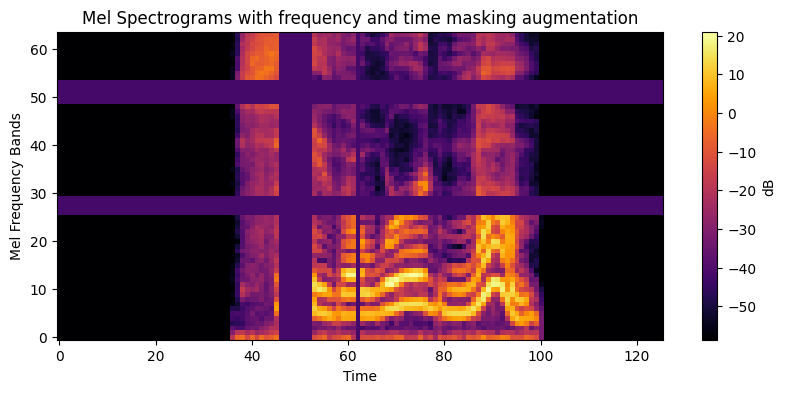

In [28]:
# Check size of mel spectrogram at the end: 
# e.g. (num_channels, Mel freq_bands, time_steps in spec) = (2, 64, 344)
sample_data, _ = next(iter(train_loader))
print("Shape of sample_data: ", "(batch_sz, num_channels, Mel freq_bands, time_steps)", sample_data.shape)
# torch.Size([16, 1, 64, 126])

mel_spectrogram = sample_data[0]

mel_shape = mel_spectrogram.shape
print("Shape of Mel Spectrogram:", "(num_channels, Mel freq_bands, time_steps in spec)", mel_shape, "\n")
# torch.Size([1, 64, 126])

# Spectrogram for 1st channel
mel_spectrogram = sample_data[0]

mel_spectrogram = mel_spectrogram.squeeze()

# Plot the Mel Spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram.numpy(), cmap='inferno', origin='lower')

n_freq_masks = 2
n_time_masks = 2

# Overlay frequency and time masking
for _ in range(n_freq_masks):
    freq_mask_range = torch.randint(1, mel_spectrogram.size(0)//2, (1,)).item()
    freq_mask_start = torch.randint(0, mel_spectrogram.size(0) - freq_mask_range, (1,)).item()
    mel_spectrogram[freq_mask_start:freq_mask_start+freq_mask_range, :] = mel_spectrogram.mean()

for _ in range(n_time_masks):
    time_mask_range = torch.randint(1, mel_spectrogram.size(1)//2, (1,)).item()
    time_mask_start = torch.randint(0, mel_spectrogram.size(1) - time_mask_range, (1,)).item()
    mel_spectrogram[:, time_mask_start:time_mask_start+time_mask_range] = mel_spectrogram.mean()

plt.title('Mel Spectrograms with frequency and time masking augmentation')
plt.xlabel('Time')
plt.ylabel('Mel Frequency Bands')
plt.colorbar(label='dB')
plt.show()

In [15]:
"""
Building Network architecture based on the paper:
Human–Computer Interaction with a Real-Time Speech
Emotion Recognition with Ensembling Techniques 1D
Convolution Neural Network and Attention
(https://doi.org/10.3390/s23031386)

We are taking the output of CNN as the input of LSTM.
CNN captures local patterns in audio features, and
LSTM learns temporal dependencies before making final prediction. This supports
robust sequence prediction.
"""
def nonlinearity(x):
    ''' Also called the activation function. '''
    return torch.nn.functional.softmax(x, dim=-1)

class CNN_LSTM(nn.Module):
    def __init__(self, num_emotions):
        super(CNN_LSTM, self).__init__()
        # bn = batch normalization
        ####################
        # Convolution blocks: conv, batch norm, ReLU, max pooling
        # Conv block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=(1,1), padding=(2,2))
        self.bn1 = nn.BatchNorm2d(8)

        # Conv block 2
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.bn2 = nn.BatchNorm2d(16)

        # Conv block 3
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding =(1,1))
        self.bn3 = nn.BatchNorm2d(32)

        # Conv block 4
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding =(1,1))
        self.bn4 = nn.BatchNorm2d(64)

        # Conv block 5
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding =(1,1))
        self.bn5 = nn.BatchNorm2d(128)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        ####################

        ####################
        # LSTM + attention block
        hidden_size=64
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=hidden_size, bidirectional=False, batch_first = True)

        self.attention_linear = nn.Linear(hidden_size, 1)
        self.softmax = nn.Softmax(dim=1)

        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, bidirectional=False, batch_first = True)
        ####################


        self.fc1 = nn.Linear(hidden_size, 64)
        self.bn6 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, num_emotions)


    def forward(self, x):
        # Conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)

        # Conv block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)

        # Conv block 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.pool(x)

        # Conv block 5
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.pool(x)

        # LSTM + attention block
        conv_emb = torch.flatten(x, start_dim=2) # Do not flatten batch dimension and time
        
        conv_emb = conv_emb.transpose(1, 2)  # Swap the dimensions
        conv_emb = conv_emb.reshape(conv_emb.size(0), conv_emb.size(1), -1)  # Reshape to (batch_size, time_steps, hidden_size)
        
        lstm1_out, (h,c) = self.lstm1(conv_emb) # (batch, time, hidden_size) # expects 128
        
        # Attention
        attention_weights = self.attention_linear(lstm1_out).squeeze(-1)
        attention_weights = F.softmax(attention_weights, dim=1).unsqueeze(-1)
        context_vector = torch.sum(attention_weights * lstm1_out, dim=1)

        lstm2_out, _ = self.lstm2(context_vector.unsqueeze(1))
        fc1_out = self.fc1(lstm2_out.squeeze(1))
        fc1_out = self.bn6(fc1_out)
        x = self.fc2(fc1_out)
        
        x = nonlinearity(x)

        return x

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_emotions = 4
net =  CNN_LSTM(num_emotions).to(device)
criterion = nn.CrossEntropyLoss()
optimizer =  optim.Adam(net.parameters(), lr=0.001) # 1e-4

In [17]:
print("Information on the model architecture: ", "\n")
print(net)

Information on the model architecture:  

CNN_LSTM(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm1): LSTM(12

In [18]:
"""
Training and Validation Loop.
This loop also saves calculated metrics (loss, accuracy, precision, recall, f-1 score, and fpr)
for trainging and validation in a .csv file
"""
def calculate_fpr(conf_mat): # Multi-class false pos. rate from confusion matrix
    num_classes = conf_mat.shape[0]
    
    fprs = []
    for i in range(num_classes):
        TN = np.sum(conf_mat) - np.sum(conf_mat[i,:]) - np.sum(conf_mat[:,i]) + conf_mat[i,i]
        FP = np.sum(conf_mat[:,i]) - conf_mat[i,i]
        fpr = FP / (FP + TN)
        fprs.append(fpr)
        
    mean_fprs = np.mean(fprs)
    
    return mean_fprs

def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
    
    confusion_mat = confusion_matrix(y_true, y_pred)
    fpr = calculate_fpr(confusion_mat)
    
    return precision, recall, f1, fpr

def train_and_validate(net, optimizer, device, train_loader, val_loader, criterion, num_epochs):
    if torch.cuda.is_available():
        net.cuda()
    
    root_dir = './runs'
    os.makedirs(root_dir, exist_ok=True)

    model_dir = os.path.join(root_dir, 'models_04_22')
    os.makedirs(model_dir, exist_ok=True)

    best_model_path = os.path.join(model_dir, 'best_ser_model.pth')
    
    best_val_loss = float('inf')
    
    num_batches_train = len(train_loader)
    num_batches_val = len(val_loader)

    #####
    # Training loop
    #####
    with open('train_metrics_04_22.csv', 'w', newline='') as train_metrics_file:
        train_metrics_writer = csv.writer(train_metrics_file)
        train_metrics_writer.writerow(['Epoch', 'Loss', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'FPR'])
        
        with open('valid_metrics_04_22.csv', 'w', newline='') as val_metrics_file:
            val_metrics_writer = csv.writer(val_metrics_file)
            val_metrics_writer.writerow(['Epoch', 'Loss', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'FPR'])
            
            for epoch in range(num_epochs):
                running_loss = 0
                correct_pred = 0
                total_pred = 0

                y_true_train = []
                y_pred_train = []

                trainloader_iter = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
                net.train()
                for i, data in enumerate(trainloader_iter):
                    inputs, labels = data[0].to(device), data[1].to(device)

                    # Normalize inputs
                    mean_inputs, std_inputs = inputs.mean(), inputs.std()
                    inputs = (inputs - mean_inputs) / std_inputs

                    # Initializing by zero-ing out gradient
                    optimizer.zero_grad()

                    # Forward + Backward + Optimization
                    forward_output = net(inputs) # pred
                    loss = criterion(forward_output, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()

                    # Prediction
                    _, pred_indices = torch.max(forward_output, 1)
                    label_indices = torch.argmax(labels, dim=1)

                    y_true.extend(label_indices.cpu().numpy())
                    y_pred.extend(pred_indices.cpu().numpy())

                    # Counting correct predictions
                    correct_pred += (pred_indices == label_indices).sum().item()
                    total_pred += pred_indices.shape[0]

                    # Print loss and accuracy every specified iterations
                    if (i + 1) % 50 == 0:
                        current_loss = running_loss / (i + 1)
                        current_accuracy = correct_pred / total_pred
                        print(f'Epoch: {epoch + 1}, Iteration: {i + 1}, Train Loss: {current_loss:.2f}, Train Accuracy: {current_accuracy:.2f}')
                        
#                         precision, recall, f1, fpr = calculate_metrics(y_true_train, y_pred_train)
#                         train_metrics_writer.writerow([epoch + 1, i + 1, current_loss, current_accuracy, precision, recall, f1, fpr])

                avg_loss = running_loss / num_batches_train
                accuracy = correct_pred / total_pred
                precision, recall, f1, fpr = calculate_metrics(y_true_train, y_pred_train)
                train_metrics_writer.writerow([epoch + 1, avg_loss, accuracy, precision, recall, f1, fpr])
                
                print(f'Epoch: {epoch + 1}, Loss: {avg_loss:.2f}, Accuracy: {accuracy:.2f}')


                #####
                # Validation loop
                #####
                running_loss = 0.0
                correct_pred = 0
                total_pred = 0
                y_true_val = []
                y_pred_val = []
                
                with torch.no_grad():
                    val_loader_iter = tqdm(val_loader, desc=f'Validation Epoch {epoch + 1}/{num_epochs}', leave=False)
                    net.eval()
                    for j, data in enumerate(val_loader_iter):
                        inputs, labels = data[0].to(device), data[1].to(device)

                        # Normalize inputs
                        mean_inputs, std_inputs = inputs.mean(), inputs.std()
                        inputs = (inputs - mean_inputs) / std_inputs

                        # Forward + Backward + Optimization
                        forward_output = net(inputs) # pred
                        loss = criterion(forward_output, labels)

                        running_loss += loss.item()

                        # Prediction
                        _, pred_indices = torch.max(forward_output, 1)
                        label_indices = torch.argmax(labels, dim=1)

                        y_true.extend(label_indices.cpu().numpy())
                        y_pred.extend(pred_indices.cpu().numpy())


                        # Counting correct predictions
                        correct_pred += (pred_indices == label_indices).sum().item()
                        total_pred += pred_indices.shape[0]

                        # Print loss and accuracy every specified iterations
                        if (j + 1) % 50 == 0:
                            current_loss = running_loss / (j + 1)
                            current_accuracy = correct_pred / total_pred
                            print(f'Epoch: {epoch + 1}, Iteration: {j + 1}, Val Loss: {current_loss:.2f}, Val Accuracy: {current_accuracy:.2f}')
#                             precision, recall, f1, fpr = calculate_metrics(y_true_val, y_pred_val)
#                             val_metrics_writer.writerow([epoch + 1, j + 1, current_loss, current_accuracy, precision, recall, f1, fpr])
                    
        
                    # Calculating metrics for validation
                    avg_loss = running_loss / num_batches_val
                    accuracy = correct_pred / total_pred
                    precision, recall, f1, fpr = calculate_metrics(y_true_val, y_pred_val)
                    print(f'Epoch: {epoch + 1}, Val Loss: {avg_loss:.2f}, Val Accuracy: {accuracy:.2f}')
                    
                    val_metrics_writer.writerow([epoch + 1, j + 1, avg_loss, accuracy, precision, recall, f1, fpr])
                    
                    # Saving the best model
                    if avg_loss < best_val_loss:
                        print("MODEL UPDATED")
                        best_val_loss = avg_loss
                        torch.save({
                            'model_state_dict': net.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            }, best_model_path)
                    
                    # Saving model after each epoch
                    epoch_model_path = os.path.join(model_dir, f'see_epoch{epoch + 1}.pth')
                    torch.save({
                        'model_state_dict': net.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                    }, epoch_model_path)

            print('Finished Training and Validating')
    return net


In [19]:
Net = train_and_validate(net, optimizer, device, train_loader, val_loader, criterion, num_epochs=10)

In [26]:
# Testing Loop
def test(net, device, test_loader, criterion, text_file_name='name'):
    best_accuracy = float('-inf')
    if torch.cuda.is_available():
        net.cuda()
    
    test_metrics_file = open(text_file_name, 'w', newline='')  
    test_metrics_writer = csv.writer(test_metrics_file)  
    test_metrics_writer.writerow(['Iteration', 'Loss', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'FPR'])
    
    net.eval()
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        test_loader_iter = tqdm(test_loader, desc='Testing', leave=False)
        for i, data in enumerate(test_loader_iter):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize inputs
            mean_inputs, std_inputs = inputs.mean(), inputs.std()
            inputs = (inputs - mean_inputs) / std_inputs

            # Forward + Backward + Optimization
            forward_output = net(inputs)
            loss = criterion(forward_output, labels)

            running_loss += loss.item()

            # Prediction
            _, pred_indices = torch.max(forward_output, 1)
            label_indices = torch.argmax(labels, dim=1)
            
            y_true.extend(label_indices.cpu().numpy())
            y_pred.extend(pred_indices.cpu().numpy())

            # Counting correct predictions
            correct_pred += (pred_indices == label_indices).sum().item()
            total_pred += pred_indices.shape[0]

            # Print loss and accuracy every specified iterations
            if (i + 1) % 20 == 0:
                current_loss = running_loss / (i + 1)
                current_accuracy = correct_pred / total_pred
                print(f'Iteration: {i + 1}, Test Loss: {current_loss:.2f}, Test Accuracy: {current_accuracy:.2f}')
            
            curr_accuracy = correct_pred / total_pred
            if curr_accuracy > best_accuracy:
                best_accuracy = curr_accuracy
                best_confusion_matrix = confusion_matrix(y_true, y_pred)

            # Calculating metrics for validation
            precision, recall, f1_score, fpr = calculate_metrics(y_true, y_pred)
            avg_loss = running_loss / (i + 1)
            accuracy = correct_pred / total_pred
            test_metrics_writer.writerow([i + 1, avg_loss, accuracy, precision, recall, f1_score, fpr]) # Test this later

    print("Confusion matrix for testing: ", "\n", best_confusion_matrix, "\n")
        
    print(f'Test Loss: {avg_loss:.2f}, Test Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1_score:.2f}, FPR: {fpr:.2f}')
    
    return

In [21]:
# Load model to do testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_emotions = 4
model =  CNN_LSTM(num_emotions).to(device)

# Training was killed at mid 185 epochs
checkpoint = torch.load('./runs/models_04_22_200Epochs/ser_epoch184.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

CNN_LSTM(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm1): LSTM(128, 64, batch_first=True)
  (attention_line

In [27]:
test(model, device, test_loader, criterion, text_file_name='test_metrics_184Epochs.csv')

Testing:  15%|█▌        | 20/132 [03:13<20:39, 11.06s/it]

Iteration: 20, Test Loss: 0.87, Test Accuracy: 0.87


Testing:  30%|███       | 40/132 [06:16<13:43,  8.95s/it]

Iteration: 40, Test Loss: 0.91, Test Accuracy: 0.83


Testing:  45%|████▌     | 60/132 [08:49<10:25,  8.69s/it]

Iteration: 60, Test Loss: 0.92, Test Accuracy: 0.82


Testing:  61%|██████    | 80/132 [11:23<05:37,  6.49s/it]

Iteration: 80, Test Loss: 0.93, Test Accuracy: 0.81


Testing:  76%|███████▌  | 100/132 [14:24<03:59,  7.50s/it]

Iteration: 100, Test Loss: 0.93, Test Accuracy: 0.81


Testing:  91%|█████████ | 120/132 [16:13<00:54,  4.52s/it]

Iteration: 120, Test Loss: 0.94, Test Accuracy: 0.80


Confusion matrix for testing:  
 [[3 0 0 0]
 [1 2 0 0]
 [0 0 3 0]
 [0 0 0 7]] 

Test Loss: 0.93, Test Accuracy: 0.81, Precision: 0.81, Recall: 0.81, F1 Score: 0.81, FPR: 0.06


In [29]:
import re
# Extracting loss and accuracy for training and validation (each epoch) from object file that is obtained 
# from submitting batch job in SCC

def extract_loss_accuracy(filename):
    with open(filename, 'r') as file:
        data = file.read()

    train_epochs = re.findall(r'Epoch: (\d+), Loss: ([\d.]+), Accuracy: ([\d.]+)', data)
    val_epochs = re.findall(r'Epoch: (\d+), Val Loss: ([\d.]+), Val Accuracy: ([\d.]+)', data)

    return train_epochs, val_epochs

file_path = "./object_file_184Epochs.txt"
train_epochs, val_epochs = extract_loss_accuracy(file_path)

epoch_values = []
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

epoch_values = [float(epoch) for epoch, _, _ in train_epochs]
train_loss = [float(loss) for _, loss, _ in train_epochs]
train_accuracy = [float(accuracy) for _, _, accuracy in train_epochs]

val_loss = [float(loss) for _, loss, _ in val_epochs]
val_accuracy = [float(accuracy) for _, _, accuracy in val_epochs]

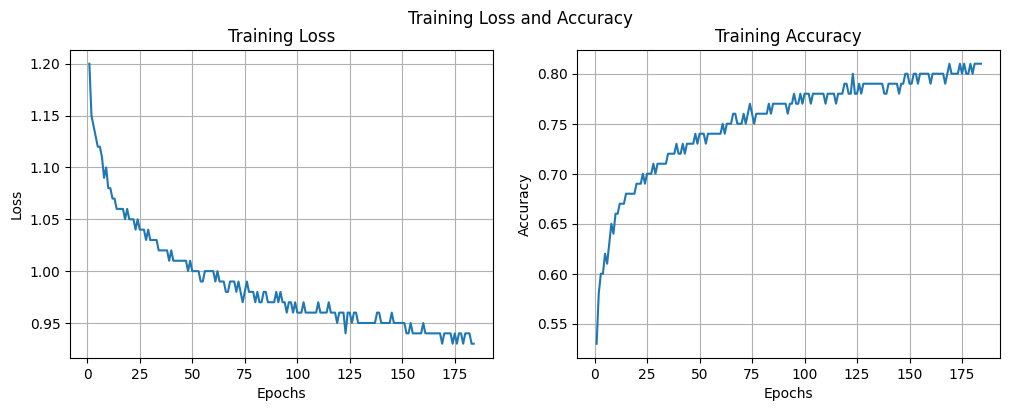

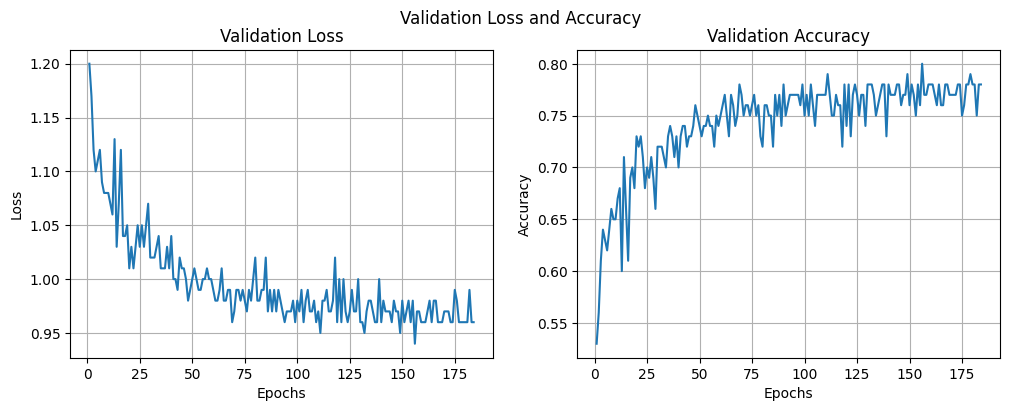

In [30]:
# Visualizing extracted loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Training Loss and Accuracy')
ax1.plot(epoch_values, train_loss)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

ax2.plot(epoch_values, train_accuracy)
ax2.set_title('Training Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid(True)

fig, (ax3, ax4) =  plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Validation Loss and Accuracy')
ax3.plot(epoch_values, val_loss)
ax3.set_title('Validation Loss')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.grid(True)

ax4.plot(epoch_values, val_accuracy)
ax4.set_title('Validation Accuracy')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Accuracy')
ax4.grid(True)

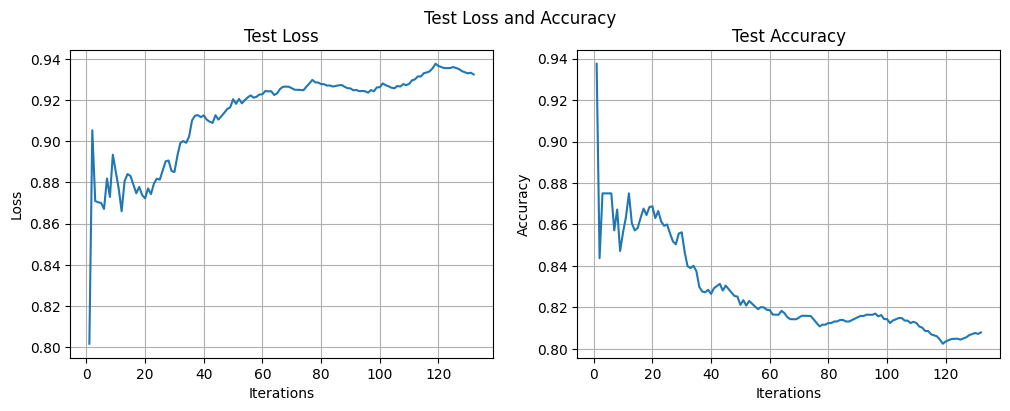

In [31]:
# Visualizing loss and accuracy after testing
test_file_path = ('./test_metrics_184Epochs.csv')

df = pd.read_csv(test_file_path)

iteration = df['Iteration']
loss = df['Loss']
accuracy = df['Accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Test Loss and Accuracy')
ax1.plot(iteration, loss)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.set_title('Test Loss')
ax1.grid(True)

ax2.plot(iteration, accuracy)
ax2.set_title('Test Accuracy')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Accuracy')
ax2.grid(True)


In [32]:
# Printing average loss and accuracy for testing data
mean_loss_test = loss.mean()
mean_accuracy_test = accuracy.mean()

print(f"Mean loss for testing: {mean_loss_test}")
print(f"Mean accuracy for testing: {mean_accuracy_test}")

Mean loss for testing: 0.9133440482229975
Mean accuracy for testing: 0.8275158680173026
